In [1]:
import cs109style
cs109style.customize_mpl()
cs109style.customize_css()

# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import requests
from pattern import web



Setting custom matplotlib visual style
Setting custom CSS for the IPython Notebook


## Fetching population data from Wikipedia

In this example we will fetch data about countries and their population from Wikipedia.

http://en.wikipedia.org/wiki/List_of_countries_by_past_and_future_population has several tables for individual countries, subcontinents as well as different years. We will combine the data for all countries and all years in a single panda dataframe and visualize the change in population for different countries.

###We will go through the following steps:
* fetching html with embedded data
* parsing html to extract the data
* collecting the data in a panda dataframe
* displaying the data

To give you some starting points for your homework, we will also show the different sub-steps that can be taken to reach the presented solution.

## Fetching the Wikipedia site

In [2]:
url = 'http://en.wikipedia.org/wiki/List_of_countries_by_past_and_future_population'
website_html = requests.get(url).text
print website_html

<!DOCTYPE html>
<html lang="en" dir="ltr" class="client-nojs">
<head>
<meta charset="UTF-8" />
<title>List of countries by past and future population - Wikipedia, the free encyclopedia</title>
<meta name="generator" content="MediaWiki 1.26wmf8" />
<link rel="alternate" href="android-app://org.wikipedia/http/en.m.wikipedia.org/wiki/List_of_countries_by_past_and_future_population" />
<link rel="alternate" type="application/x-wiki" title="Edit this page" href="/w/index.php?title=List_of_countries_by_past_and_future_population&amp;action=edit" />
<link rel="edit" title="Edit this page" href="/w/index.php?title=List_of_countries_by_past_and_future_population&amp;action=edit" />
<link rel="apple-touch-icon" href="/static/apple-touch/wikipedia.png" />
<link rel="shortcut icon" href="/static/favicon/wikipedia.ico" />
<link rel="search" type="application/opensearchdescription+xml" href="/w/opensearch_desc.php" title="Wikipedia (en)" />
<link rel="EditURI" type="application/rsd+xml" href="//en.w

## Parsing html data

In [10]:
def get_population_html_tables(html):
    """Parse html and return html tables of wikipedia population data."""

    dom = web.Element(html)

    ### 0. step: look at html source!
    
    #### 1. step: get all tables
    # tbls = dom('table')

    #### 2. step: get all tables we care about
    tbls = dom.by_class('sortable wikitable')

    return tbls

tables = get_population_html_tables(website_html)
print "table length: %d" %len(tables)
for t in tables:
    print t.attributes


table length: 6
{u'style': u'text-align: right', u'class': u'sortable wikitable'}
{u'style': u'text-align: right', u'class': u'sortable wikitable'}
{u'style': u'text-align: right', u'class': u'sortable wikitable'}
{u'style': u'text-align: right', u'class': u'sortable wikitable'}
{u'style': u'text-align: right', u'class': u'sortable wikitable'}
{u'style': u'text-align: right', u'class': u'sortable wikitable'}


In [17]:
def table_type(tbl):
    ### Extract the table type
    return tbl('th')[0].content

# group the tables by type - method 1
#table_by_type = {}
#for tbl in tables:
#    typ = table_type(tbl)
#    if typ in table_by_type:
#        table_by_type[type].append(table)
#    else:
#        table_by_type[typ] = [table]

# group the tables by type - method 2
tables_by_type = defaultdict(list)  
# defaultdicts have a default value that is inserted when a new key is accessed

for tbl in tables:
    tables_by_type[table_type(tbl)].append(tbl)

print tables_by_type

defaultdict(<type 'list'>, {u'Country or territory': [Element(tag=u'table'), Element(tag=u'table'), Element(tag=u'table')], u'(Sub)continent': [Element(tag=u'table'), Element(tag=u'table'), Element(tag=u'table')]})


## Extracting data and filling it into a dictionary

In [32]:
def get_countries_population(tables):
    """Extract population data for countries from all tables and store it in dictionary."""
    
    result = defaultdict(dict)

    # 1. step: try to extract data for a single table
    for tbl in tables:
        headers = tbl('tr')
        first_header = headers[0]
        th_s = first_header('th')
        years = [int(val.content) for val in th_s if val.content.isnumeric()]
        year_indices = [idx for idx, val in enumerate(th_s) if val.content.isnumeric()]
        print years
        print year_indices
        # 2. step: iterate over all tables, extract headings and actual data and combine data into single dict
        rows = tbl('tr')[1:]
        for row in rows:
            tds = row('td')
            country_name = tds[0]('a')[0].content
            population_by_year = [int(tds[colidx].content.replace(',',''))
                                  for colidx in year_indices]
            subdict = dict((zip(years, population_by_year)))
            result[country_name].update(subdict)
        
    
    return result


result = get_countries_population(tables_by_type['Country or territory'])
print len(result), "Countries extracted"
print result['Canada']

[1950, 1955, 1960, 1965, 1970, 1975, 1980]
[1, 2, 4, 6, 8, 10, 12]
[1985, 1990, 1995, 2000, 2005, 2010, 2015]
[1, 3, 5, 7, 9, 11, 13]
[2020, 2025, 2030, 2035, 2040, 2045, 2050]
[1, 3, 5, 7, 9, 11, 13]
227 Countries extracted
{1985: 25942, 2050: 41136, 1955: 16050, 2020: 36387, 1990: 27791, 1960: 18267, 2025: 37559, 1995: 29691, 1965: 20071, 2030: 38565, 2000: 31100, 1970: 21750, 2035: 39396, 2005: 32386, 1975: 23209, 2040: 40070, 2010: 33760, 1980: 24593, 2045: 40635, 1950: 14011, 2015: 35100}


## Creating a dataframe from a dictionary

In [33]:
# create dataframe

df = pd.DataFrame.from_dict(result, orient='index')
# sort based on year
df.sort(axis=1,inplace=True)
print df


                                1950    1955    1960    1965    1970    1975  \
Afghanistan                     8150    8891    9829   10998   12431   14132   
Albania                         1227    1392    1623    1884    2157    2401   
Algeria                         8893    9842   10909   11963   13932   16140   
American Samoa                    19      20      20      25      27      30   
Andorra                            6       6       8      14      20      27   
Angola                          4118    4423    4797    5135    5606    6050   
Anguilla                           5       5       6       6       6       6   
Antigua and Barbuda               46      51      55      59      66      68   
Argentina                      17150   18928   20616   22283   23962   26082   
Armenia                         1355    1565    1869    2206    2520    2834   
Aruba                             50      54      57      59      59      59   
Australia                       8267    

## Some data accessing functions for a panda dataframe

In [34]:
subtable = df.iloc[0:2, 0:2]
print "subtable"
print subtable
print ""

column = df[1955]
print "column"
print column
print ""

row = df.ix[0] #row 0
print "row"
print row
print ""

rows = df.ix[:2] #rows 0,1
print "rows"
print rows
print ""

element = df.ix[0,1955] #element
print "element"
print element
print ""

# max along column
print "max"
print df[1950].max()
print ""

# axes
print "axes"
print df.axes
print ""

row = df.ix[0]
print "row info"
print row.name
print row.index
print ""

countries =  df.index
print "countries"
print countries
print ""

print "Austria"
print df.ix['Austria']

subtable
             1950  1955
Afghanistan  8150  8891
Albania      1227  1392

column
Afghanistan                       8891
Albania                           1392
Algeria                           9842
American Samoa                      20
Andorra                              6
Angola                            4423
Anguilla                             5
Antigua and Barbuda                 51
Argentina                        18928
Armenia                           1565
Aruba                               54
Australia                         9277
Austria                           6947
Azerbaijan                        3314
Bahamas                             87
Bahrain                            130
Bangladesh                       49588
Barbados                           227
Belarus                           7781
Belgium                           8868
Belize                              77
Benin                             1846
Bermuda                             41
Bhutan        

## Plotting population of 4 countries

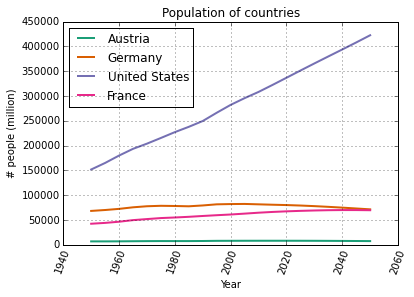

In [35]:
plotCountries = ['Austria', 'Germany', 'United States', 'France']
    
for country in plotCountries:
    row = df.ix[country]
    plt.plot(row.index, row, label=row.name ) 
    
plt.ylim(ymin=0) # start y axis at 0

plt.xticks(rotation=70)
plt.legend(loc='best')
plt.xlabel("Year")
plt.ylabel("# people (million)")
plt.title("Population of countries")

## Plot 5 most populous countries from 2010 and 2060

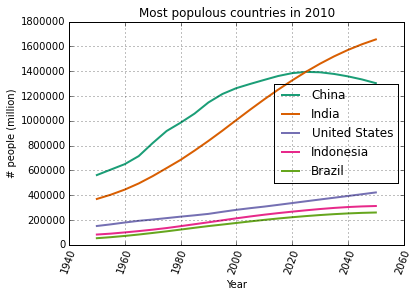

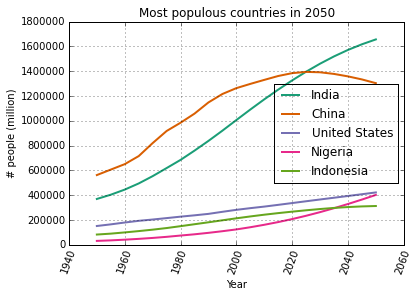

In [36]:
def plot_populous(df, year):
    # sort table depending on data value in year column
    df_by_year = df.sort(year, ascending=False)
    
    plt.figure()
    for i in range(5):  
        row = df_by_year.ix[i]
        plt.plot(row.index, row, label=row.name ) 
            
    plt.ylim(ymin=0)
    
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Year")
    plt.ylabel("# people (million)")
    plt.title("Most populous countries in %d" % year)

plot_populous(df, 2010)
plot_populous(df, 2050)